### Markov Decision Process and Policy Iteration

#### Introduction to Markov Decision Processes

A **Markov Decision Process (MDP)** provides the mathematical framework for modeling decision-making problems in environments where outcomes are partly random and partly under the control of a decision maker. In this notebook, I implement and demonstrate the **Policy Iteration** algorithm for deterministic environment, one of the fundamental dynamic programming methods for solving MDPs.

##### Mathematical Formulation

An MDP is formally defined as a tuple $(S, A, P, R, \gamma)$ where:

- $S$ is the finite set of **states**
- $A$ is the finite set of **actions** 
- $P(s'|s,a)$ is the **state transition probability** function
- $R(s,a,s')$ is the **reward function**
- $\gamma \in [0,1]$ is the **discount factor**

##### The Markov Property

The key assumption is the **Markov property**: the future state depends only on the current state and action, not on the sequence of events that led to the current state:

$$P(S_{t+1} = s' | S_t = s, A_t = a, S_{t-1}, A_{t-1}, ..., S_0, A_0) = P(S_{t+1} = s' | S_t = s, A_t = a)$$

This notebook demonstrates these concepts using the **FrozenLake** environment as our MDP.

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output

#### Environment Setup: FrozenLake MDP

![env](https://gymnasium.farama.org/_images/frozen_lake.gif)

The **FrozenLake** environment represents a grid world where an agent must navigate from a starting position to a goal while avoiding holes. This serves as an excellent example of an MDP because:

##### State Space ($S$)
- The states represent the agent's position on the 4×4 grid
- $|S| = 16$ states (positions 0-15)
- Each state corresponds to a specific location: $(row, column)$

##### Action Space ($A$)  
- Four possible actions: $A = \{0, 1, 2, 3\}$
- Action mapping: $\{0: \text{Left}, 1: \text{Down}, 2: \text{Right}, 3: \text{Up}\}$
- $|A| = 4$ actions available from each state

##### Transition Function ($P$)
- In deterministic mode: $P(s'|s,a) = 1$ for the intended next state, $0$ otherwise
- In stochastic mode: the agent might slip and move in unintended directions

##### Reward Function ($R$)
- $R = +1$ when reaching the goal state
- $R = 0$ for all other transitions
- The objective is to maximize expected cumulative reward


Let's create and examine this environment:

In [2]:

env = gym.make('FrozenLake-v1', map_name='4x4', render_mode='rgb_array', is_slippery=False)

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Discrete(16)
Action space: Discrete(4)


In [3]:
env.reset()

(0, {'prob': 1})

In [4]:
# display the board
def render_board():
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()

/home/arun/venvs/global_env/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


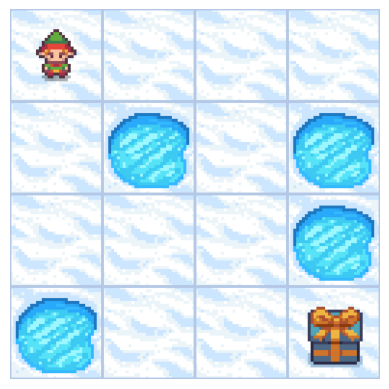

In [5]:
# display initial game state
render_board()

In [6]:
# Action Mapping
action_dict = {0: "Left", 1: "Down", 2: "Right", 3: "Up"}

#### Random Policy Exploration

Before implementing optimal policies, let's observe the behavior of a **random policy**. A random policy selects actions uniformly at random:

$$\pi_{random}(a|s) = \frac{1}{|A|} = \frac{1}{4} \quad \forall s \in S, a \in A$$

This exploration helps us understand:
- The environment dynamics
- The challenges of the navigation task
- Why we need optimal policy computation

Random policies typically perform poorly because they don't leverage knowledge of the environment structure or goal location.

Selected Action: Down


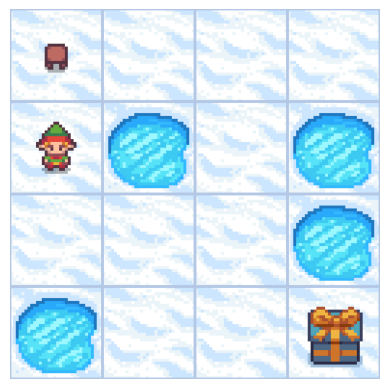

Selected Action: Down


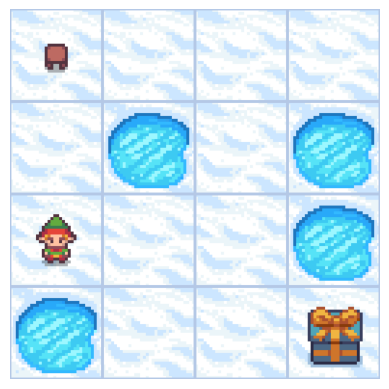

Selected Action: Right


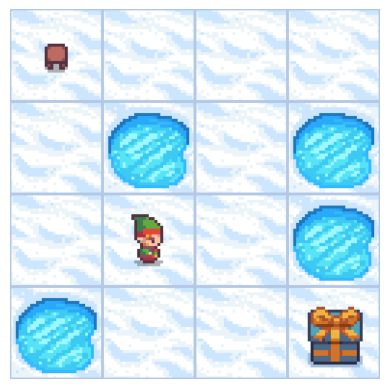

Selected Action: Right


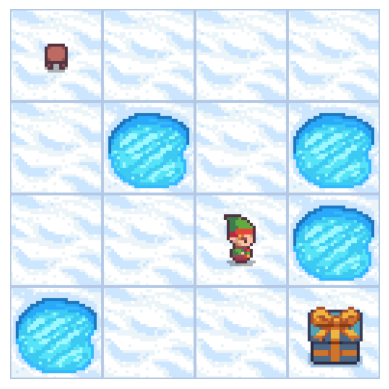

Selected Action: Down


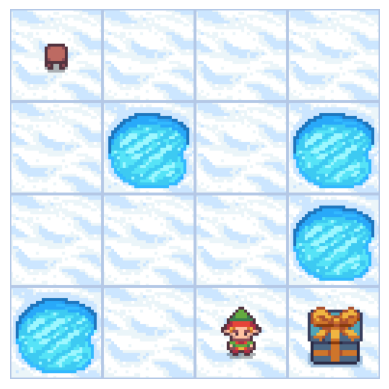

Selected Action: Down


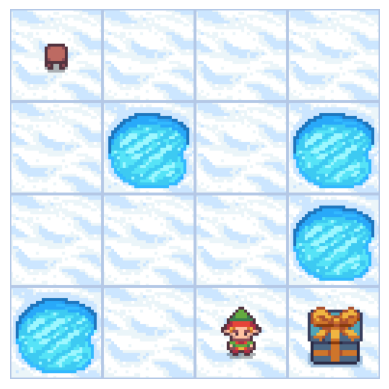

Selected Action: Down


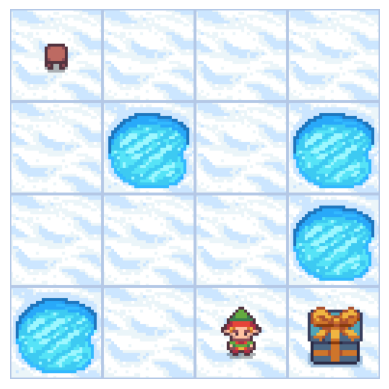

Selected Action: Down


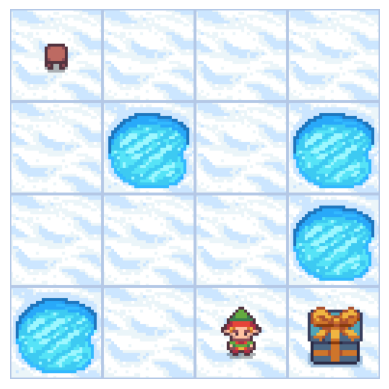

Selected Action: Up


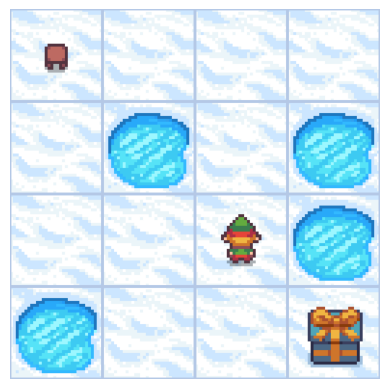

Selected Action: Down


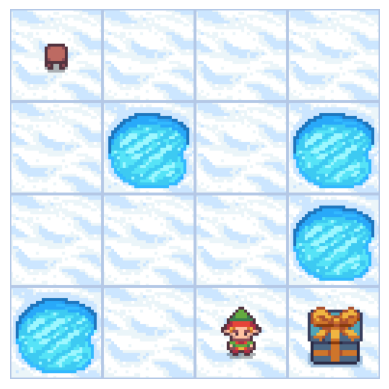

In [7]:
# game loop
for _ in range(10):
    
    # pick random action from action space
    action = env.action_space.sample()

    print("Selected Action:", action_dict[action])

    obs, reward, done, truncated, _  = env.step(action)

    # clear_output()
    render_board()

    if done:
        print(f"Game over. Reward: {reward}")
        break

env.close()

#### Deterministic vs Stochastic MDPs

The distinction between deterministic and stochastic environments is fundamental in MDP theory:

##### Deterministic MDP
In a deterministic MDP, the transition function is deterministic:
$$P(s'|s,a) = \begin{cases}
1 & \text{if } s' \text{ is the unique next state from } s \text{ given } a \\
0 & \text{otherwise}
\end{cases}$$

##### Stochastic MDP  
In a stochastic MDP, transitions are probabilistic:
$$\sum_{s' \in S} P(s'|s,a) = 1 \quad \forall s \in S, a \in A$$

The environment can transition to multiple possible next states with different probabilities.

Let's examine the transition probabilities for both cases:

##### Deterministic MDP Analysis

In the deterministic FrozenLake environment (`is_slippery=False`), each action leads to exactly one next state. The transition probability matrix has the form:

$$P(s'|s,a) = \begin{cases}
1 & \text{if } s' = f(s,a) \\
0 & \text{otherwise}
\end{cases}$$

where $f(s,a)$ is the deterministic transition function. Let's examine the transition probabilities:

In [8]:
mdp = env.unwrapped.P

state_0_mdp = mdp[0]

state_0_mdp 

# {action_i: [(prob, new_state, reward, done)]}

{0: [(1.0, 0, 0.0, False)],
 1: [(1.0, 4, 0.0, False)],
 2: [(1.0, 1, 0.0, False)],
 3: [(1.0, 0, 0.0, False)]}

In [9]:
state_14_mdp = mdp[14]

state_14_mdp 

# only taking action 2 (Right) at 14th state will end the game

{0: [(1.0, 13, 0.0, False)],
 1: [(1.0, 14, 0.0, False)],
 2: [(1.0, 15, 1.0, True)],
 3: [(1.0, 10, 0.0, False)]}

##### Stochastic Environment Analysis

In the stochastic FrozenLake environment (`is_slippery=True`), the agent can slip and move in unintended directions. The transition probabilities become:

$$P(s'|s,a) = \begin{cases}
\frac{1}{3} & \text{for each of the three possible next states} \\
0 & \text{otherwise}
\end{cases}$$

This introduces uncertainty and makes optimal policy computation more challenging. The agent must account for the possibility of unintended movements when selecting actions.

In [10]:
slippery_env = gym.make('FrozenLake-v1', map_name='4x4', render_mode='rgb_array', is_slippery=True)

slippery_env.reset()

(0, {'prob': 1})

In [11]:
slippery_mdp = slippery_env.unwrapped.P

slippery_state_0_mdp = slippery_mdp[0]
slippery_state_0_mdp
#{action_i : [(prob, new_state, reward, done)]}

{0: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

#### Policy Iteration Algorithm: Theory and Implementation

**Policy Iteration** is a fundamental dynamic programming algorithm for solving MDPs. It consists of two alternating steps that are guaranteed to converge to the optimal policy.

##### Mathematical Foundation

**Policy Definition**  
A **policy** $\pi$ is a mapping from states to actions:
- **Deterministic policy**: $\pi: S \rightarrow A$
- **Stochastic policy**: $\pi: S \times A \rightarrow [0,1]$ where $\sum_{a} \pi(a|s) = 1$

**Value Function**  
The **state value function** $V^\pi(s)$ represents the expected cumulative discounted reward when starting from state $s$ and following policy $\pi$:

$$V^\pi(s) = \mathbb{E}_\pi\left[\sum_{t=0}^{\infty} \gamma^t R_{t+1} | S_0 = s\right]$$

**The Bellman Equation for Policy Evaluation**  
For a given policy $\pi$, the value function satisfies:

$$V^\pi(s) = \sum_{a} \pi(a|s) \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V^\pi(s')]$$

**Policy Iteration Steps**

1. **Policy Evaluation**: Compute $V^\pi$ for current policy $\pi$
2. **Policy Improvement**: Update policy greedily: $\pi'(s) = \arg\max_a \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V^\pi(s')]$

The algorithm alternates between these steps until convergence (when $\pi' = \pi$).

Let's implement this algorithm step by step:

In [12]:
import numpy as np

# Environment
env = gym.make('FrozenLake-v1', map_name="4x4", render_mode="rgb_array", is_slippery=False)

# Randomly initialized policy
policy = np.random.randint(low=0, high=env.action_space.n, size=(env.observation_space.n))

policy

array([1, 2, 3, 2, 3, 0, 3, 3, 0, 2, 1, 3, 0, 3, 2, 0])

In [13]:
def print_policy(policy, grid=(4, 4)):
    
    policy_map = np.empty(grid).astype(str)

    for r in range(grid[0]):
        for c in range(grid[1]):
            index =  r * grid[0] +  c
                
            selected_action = action_dict[policy[index]]
            selected_action = selected_action[0]

            policy_map[r, c] = selected_action


    print("Policy")
    print(policy_map)

In [14]:
print_policy(policy)

Policy
[['D' 'R' 'U' 'R']
 ['U' 'L' 'U' 'U']
 ['L' 'R' 'D' 'U']
 ['L' 'U' 'R' 'L']]


#### Policy Evaluation: Computing Value Functions

**Policy Evaluation** is the first step of policy iteration where we compute the value function $V^\pi(s)$ for a given policy $\pi$.

##### Mathematical Derivation

For a deterministic policy $\pi(s)$ and deterministic environment, the Bellman equation simplifies to:

$$V^\pi(s) = \sum_{s'} P(s'|s,\pi(s))[R(s,\pi(s),s') + \gamma V^\pi(s')]$$

Since we have deterministic transitions: $P(s'|s,a) = 1$ for the unique next state, this becomes:

$$V^\pi(s) = R(s,\pi(s),s') + \gamma V^\pi(s')$$

##### Iterative Solution

We solve this system iteratively using the **Bellman operator**:

$$V_{k+1}^\pi(s) = R(s,\pi(s),s') + \gamma V_k^\pi(s')$$

Starting with $V_0^\pi(s) = 0$ for all states.

##### Convergence Theory

The iterative policy evaluation converges because:
- The Bellman operator is a **contraction mapping** with factor $\gamma$
- By the **Contraction Mapping Theorem**, there exists a unique fixed point
- Convergence rate: $||V_{k+1}^\pi - V^\pi||_\infty \leq \gamma ||V_k^\pi - V^\pi||_\infty$

Let's implement this algorithm:

In [15]:
def policy_evaluation(policy, gamma=0.99, iterations=1000, epsilon=1e-10):

    # Intialization Value with 0
    V = np.zeros(shape=env.observation_space.n)

    for _ in range(iterations):

        V_k = np.copy(V)

        # Iterate over all state
        for s in range(env.observation_space.n):

            # Select the action indicated by policy (Deterministic)
            action = policy[s]

            prob, s_next, reward, terminal = env.unwrapped.P[s][action][0]

            # Bellman equation
            V[s] = prob * (reward + gamma * V_k[s_next])

        # max abs(error) < epsilon
        if np.max(np.abs(V-V_k)) < epsilon:
            break

    return V

In [16]:
values = policy_evaluation(policy)

print("Values for given Policy:")
print(values)

Values for given Policy:
[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.9801   0.99     0.       0.       0.970299 1.       0.      ]


#### Policy Improvement: Finding Better Policies

**Policy Improvement** is the second step where we update our policy to be greedy with respect to the current value function.

##### Mathematical Foundation

Given the value function $V^\pi(s)$ from policy evaluation, we improve the policy using the **action-value function** (Q-function):

$$Q^\pi(s,a) = \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V^\pi(s')]$$

The **improved policy** is then:

$$\pi'(s) = \arg\max_{a \in A} Q^\pi(s,a)$$

##### Policy Improvement Theorem

This greedy improvement guarantees that:
$$V^{\pi'}(s) \geq V^\pi(s) \quad \forall s \in S$$

**Proof intuition**: By choosing the action that maximizes the Q-value, we select the action that yields the highest expected return from each state.

##### Deterministic Environment Simplification

In our deterministic FrozenLake environment:
$$Q^\pi(s,a) = R(s,a,s') + \gamma V^\pi(s')$$

where $s'$ is the unique next state from taking action $a$ in state $s$.

The implementation computes Q-values for all actions and selects the action with maximum Q-value:

In [17]:
def policy_improvement(values, gamma=0.99):

    new_policy = np.zeros(env.observation_space.n)

    for s in range(env.observation_space.n):

        # Q values for each action from state s
        q_sa = []

        for action in range(env.action_space.n):

            prob, s_next, reward, terminal = env.unwrapped.P[s][action][0]

            Q = prob * (reward + gamma*values[s_next])

            q_sa.append(Q)


        best_action = np.argmax(q_sa)

        new_policy[s] = best_action

    return new_policy            

In [18]:
new_policy = policy_improvement(values)
print(new_policy)

[0. 0. 0. 0. 0. 0. 1. 0. 2. 2. 1. 0. 0. 2. 2. 0.]


#### Complete Policy Iteration Algorithm

Now we combine policy evaluation and policy improvement into the complete **Policy Iteration** algorithm:

##### Algorithm Steps:

1. **Initialize** arbitrary policy $\pi_0$
2. **Repeat** until convergence:
   - **Policy Evaluation**: Compute $V^{\pi_k}$ 
   - **Policy Improvement**: $\pi_{k+1}(s) = \arg\max_a \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V^{\pi_k}(s')]$
3. **Stop** when $\pi_{k+1} = \pi_k$ (policy has converged)

##### Convergence Guarantees:

- **Finite convergence**: Policy iteration converges in finite steps (at most $|A|^{|S|}$ iterations)
- **Optimal solution**: The final policy $\pi^*$ is optimal, meaning $V^{\pi^*}(s) = V^*(s)$ for all states
- **Monotonic improvement**: Each iteration produces a policy that is at least as good as the previous one

##### Computational Complexity:

- **Per iteration**: $O(|S|^2|A|)$ for policy evaluation + $O(|S||A|)$ for policy improvement
- **Total**: $O(|S|^2|A|k)$ where $k$ is the number of policy iterations (typically small)

Let's implement the complete algorithm:

In [19]:
def policy_iteration(env, num_iterations=1000, gamma=0.99):

    policy = np.random.randint(low=0, high=env.action_space.n, size=(env.observation_space.n))

    for _ in range(num_iterations):

        values = policy_evaluation(policy, gamma=gamma, iterations=num_iterations)

        update_policy = policy_improvement(values, gamma=gamma)

        # Convergence
        if np.all(policy == update_policy):
            break

        policy = update_policy

    return policy

In [20]:
learned_policy = policy_iteration(env)
print_policy(learned_policy)

Policy
[['D' 'R' 'D' 'L']
 ['D' 'L' 'D' 'L']
 ['R' 'D' 'D' 'L']
 ['L' 'R' 'R' 'L']]


#### Optimal Policy Execution

Now we test our learned optimal policy $\pi^*$ in the environment. Since we solved the MDP exactly using policy iteration, our policy should:

##### Theoretical Guarantees:
- **Optimality**: $\pi^*(s) = \arg\max_a Q^*(s,a)$ for all states $s$
- **Value optimality**: $V^{\pi^*}(s) = V^*(s)$ (maximum possible expected return)
- **Deterministic success**: In our deterministic environment, the optimal policy should reliably reach the goal

##### Expected Behavior:
The agent should navigate efficiently from the start state (position 0) to the goal state (position 15) while avoiding holes, following the shortest safe path.

##### Performance Evaluation:
- **Success rate**: Should be 100% in deterministic environment
- **Path efficiency**: Should take the minimum number of steps to reach goal
- **Reward**: Should consistently achieve reward = 1

Let's observe our optimal policy in action:

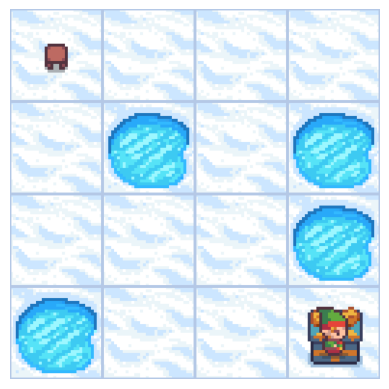

Game over, Reward: 1.0


In [21]:
observation, _ = env.reset()

observation

render_board()

for _ in range(10):

    action = int(learned_policy[observation])
    print(f"Selected action: {action_dict[action]}")

    input("Press Enter to continue")

    observation, reward, done, _, _ = env.step(action)

    clear_output()
    render_board()

    if done:
        print(f"Game over, Reward: {reward}")
        break

env.close()